In [40]:
import pandas as pd
import altair as alt
from vega_datasets import data as vega_data

# load the data
df = pd.read_csv("../data/data_science_job_posts_2025_clean.csv", low_memory=False)

alt.data_transformers.disable_max_rows()
alt.renderers.enable('svg')

RendererRegistry.enable('svg')

# Spatial Visualization 1 - Top Skill by state

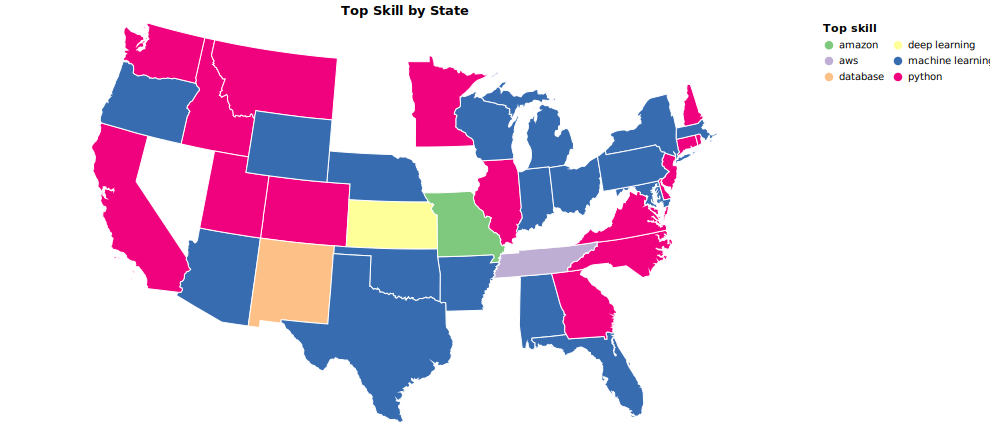

In [41]:
# explode skills
long = (
    df.assign(skill=df["skills_clean"].fillna("").str.split("|"))
      .explode("skill")
)
long = long[long["skill"].notna() & (long["skill"].str.strip() != "")]

# count per (state, skill) and pick top-1 per state
state_top_skill = (
    long.groupby(["state", "fips_int", "skill"], as_index=False)
        .size()
        .rename(columns={"size": "num_postings"})
        .sort_values(["state", "num_postings"], ascending=[True, False])
        .drop_duplicates(subset=["state"])
)
us = alt.topo_feature(vega_data.us_10m.url, "states")

chart = (
    alt.Chart(us, title="Top Skill by State")
    .mark_geoshape(stroke="white")
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(
            state_top_skill,
            key="fips_int",
            fields=["state", "skill", "num_postings"]
        )
    )
    .transform_filter("isValid(datum.num_postings)")
    .encode(
        color=alt.Color("skill:N", title="Top skill", legend=alt.Legend(columns=2), scale=alt.Scale(scheme="accent")),
        tooltip=[
            alt.Tooltip("state:N", title="State"),
            alt.Tooltip("skill:N", title="Top skill"),
            alt.Tooltip("num_postings:Q", title="# postings", format=","),
        ],
    )
    .project(type="albersUsa")
    .properties(width=800, height=400)
)

chart


# Spatial Visualization 2 - Skill vs Industry

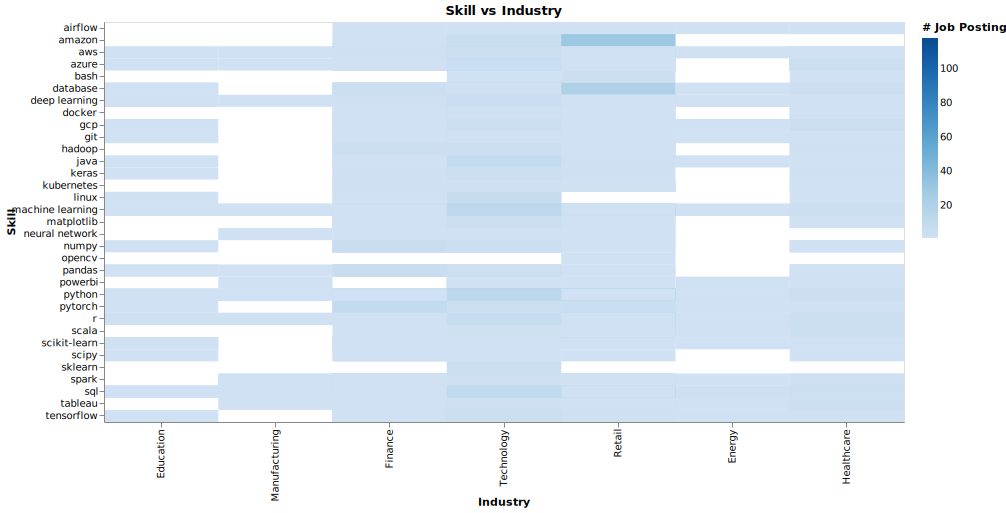

In [42]:
# aggregate: skill × industry × state
skill_industry = (
    long.groupby(["state", "industry", "skill"], as_index=False)
        .size()
        .rename(columns={"size": "num_postings"})
)

# heatmap
heatmap = (
    alt.Chart(skill_industry, title="Skill vs Industry")
    .mark_rect()
    .encode(
        x=alt.X("industry:N", title="Industry", sort="-y"),
        y=alt.Y("skill:N", title="Skill"),
        color=alt.Color(
            "num_postings:Q",
            title="# Job Postings",
            scale=alt.Scale(scheme="blues")
        ),
        tooltip=[
            alt.Tooltip("state:N", title="State"),
            alt.Tooltip("industry:N", title="Industry"),
            alt.Tooltip("skill:N", title="Skill"),
            alt.Tooltip("num_postings:Q", title="# Postings", format=","),
        ],
    )
    .properties(width=800, height=400)
)

heatmap
